# LGA Reported Offenders Number

## Reported offender data

The following files contain the information relating to persons responsible for offences.

It is important to note that QPS offender statistics are based on offence counts and do not and cannot refer to individuals. Rather, offender data refers to the number of offences cleared or solved through an action against an offender. As such, offender data does not equate to a unique offender count nor does it equate to the number of offences cleared.

Only persons 10 years and over are deemed to be offenders. As at 12 February 2018, juvenile offenders are those persons aged between 10 and 17 years (inclusive).  Before this date juvenile offenders were persons aged between 10 and 16 years (inclusive). Offenders have not been included if their age or gender is not specified in QPS records.

[Source](https://www.police.qld.gov.au/maps-and-statistics)



In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
import numpy as np
import statsmodels.api as sm
import matplotlib.cm as cm

# Constants
DATA_PATH_LGA = 'data/crime/queensland/LGA_Reported_Offenders_Number.csv'
COUNCIL_NAME = 'Douglas Shire Council'
AGE_ADULT = 'Adult'
AGE_JUVENILE = 'Juvenile'

In [2]:
def load_data(path):
    """Load data from a CSV file."""
    return pd.read_csv(path)

def filter_data_by_council(data, council_name):
    """Filter data by a specific council name."""
    return data[data['LGA Name'] == council_name]

def separate_data_by_age(data):
    """Separate data into adults and juveniles."""
    adults_data = data[data['Age'] == AGE_ADULT]
    juveniles_data = data[data['Age'] == AGE_JUVENILE]
    return adults_data, juveniles_data

def preprocess_data_for_trend_analysis(data):
    """Preprocess data for trend analysis."""
    data['Month Year'] = pd.to_datetime(data['Month Year'], format='%b-%y')
    data.set_index('Month Year', inplace=True)
    return data

def get_top_offences(data, n=5):
    """Get the top n offences."""
    offence_columns = data.columns.drop(['LGA Name', 'Month Year', 'Age', 'Sex', 'Total'])
    offence_totals = data[offence_columns].sum()
    top_offences = offence_totals.nlargest(n).index.tolist()
    return top_offences

In [3]:
# Load and preprocess data
lga_data = load_data(DATA_PATH_LGA)
douglas_data = filter_data_by_council(lga_data, COUNCIL_NAME)
adults_data, juveniles_data = separate_data_by_age(douglas_data)
juveniles_data_preprocessed = preprocess_data_for_trend_analysis(juveniles_data.copy())

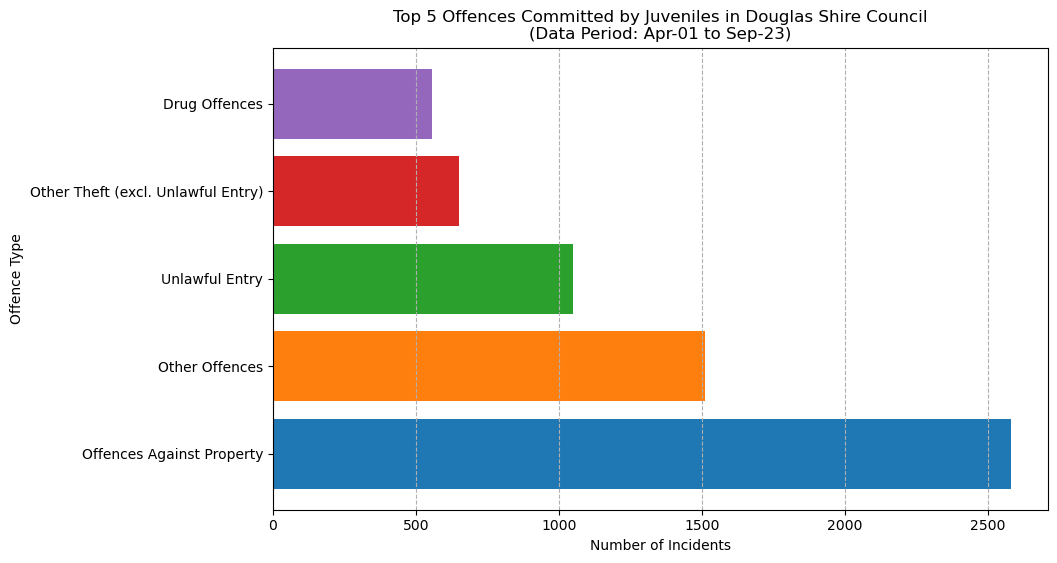

In [4]:
def plot_top_5_juvenile_offences(data):
    """Plot the top 5 offences committed by juveniles."""
    juvenile_offences_summary = data.drop(columns=['LGA Name', 'Month Year', 'Age', 'Sex', 'Total']).sum()
    top_5 = juvenile_offences_summary.sort_values(ascending=False).head(5)
    
    # Determine the data period
    data_period = f"{juveniles_data['Month Year'].min()} to {juveniles_data['Month Year'].max()}"
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_5.index, top_5.values, color=plt.cm.tab10(range(len(top_5))))
    plt.title(f'Top 5 Offences Committed by Juveniles in Douglas Shire Council\n(Data Period: {data_period})')
    plt.xlabel('Number of Incidents')
    plt.ylabel('Offence Type')
    plt.grid(axis='x', linestyle='--')
    plt.show()

# Plot top 5 juvenile offences
plot_top_5_juvenile_offences(juveniles_data)


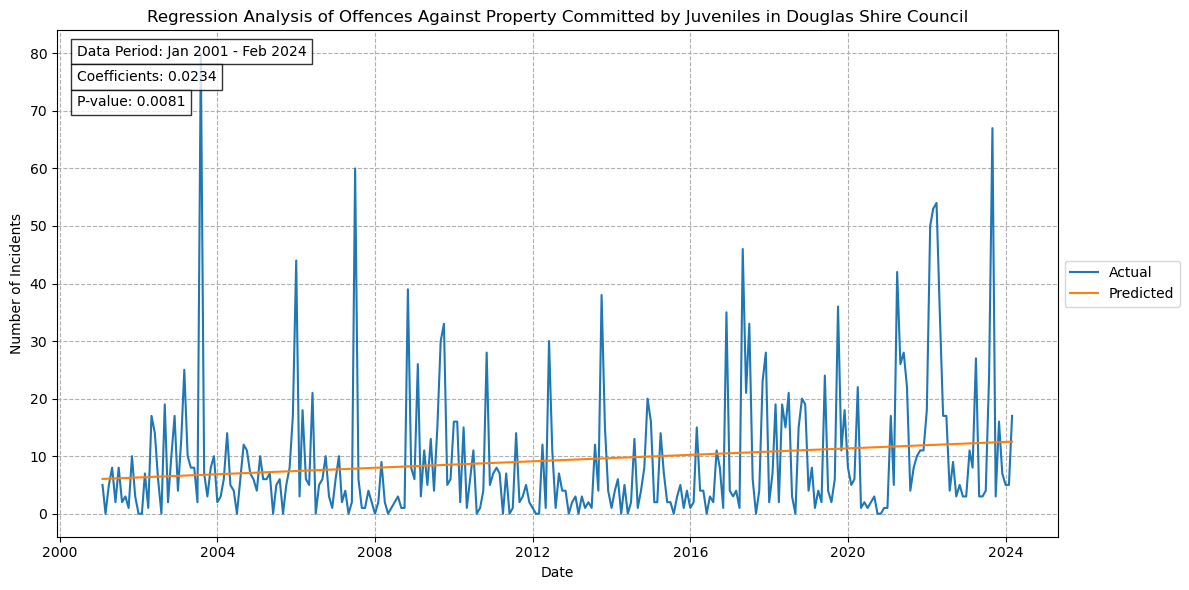

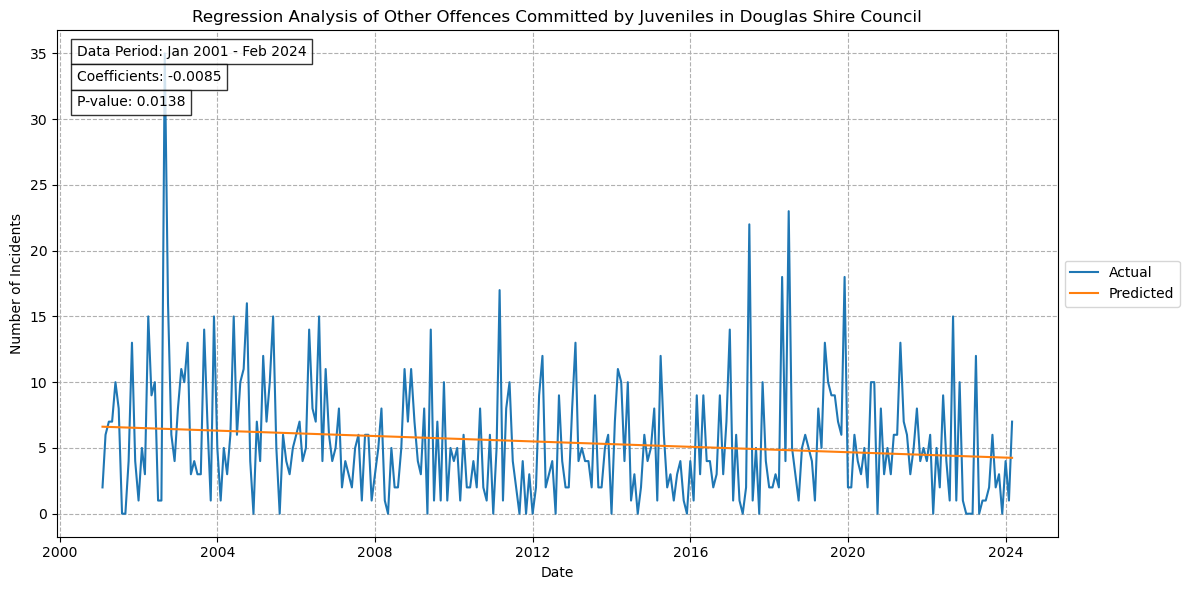

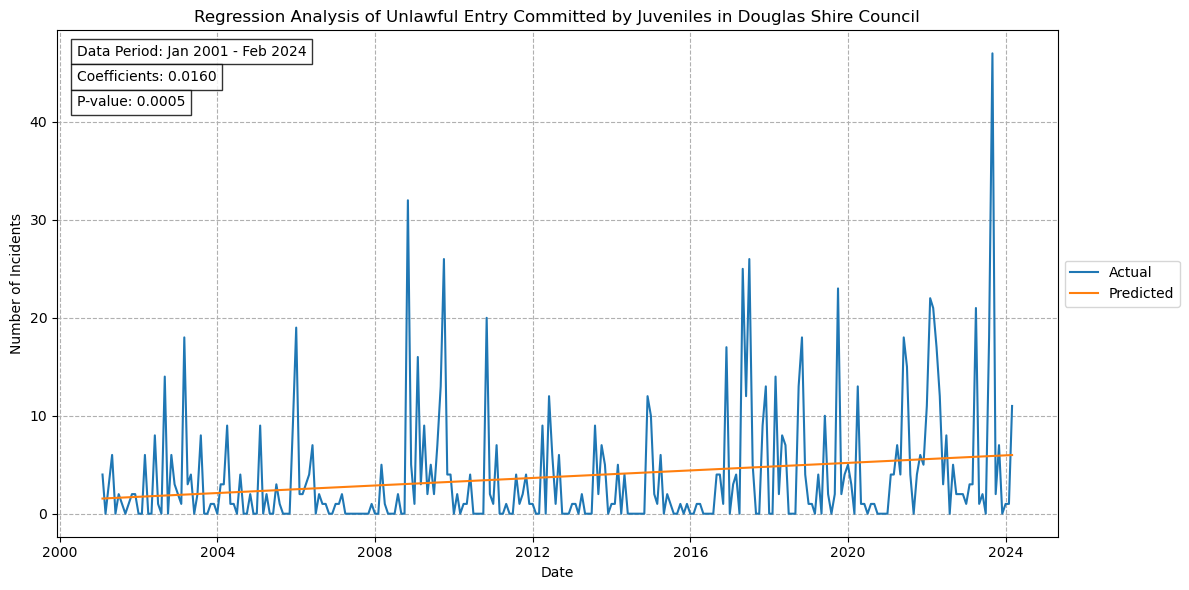

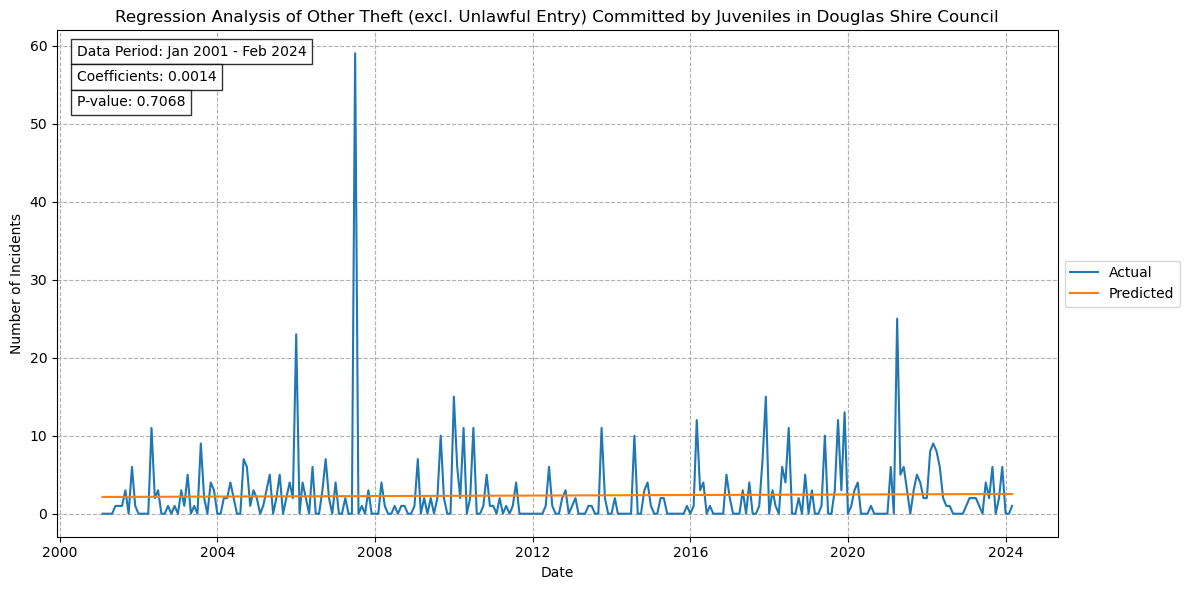

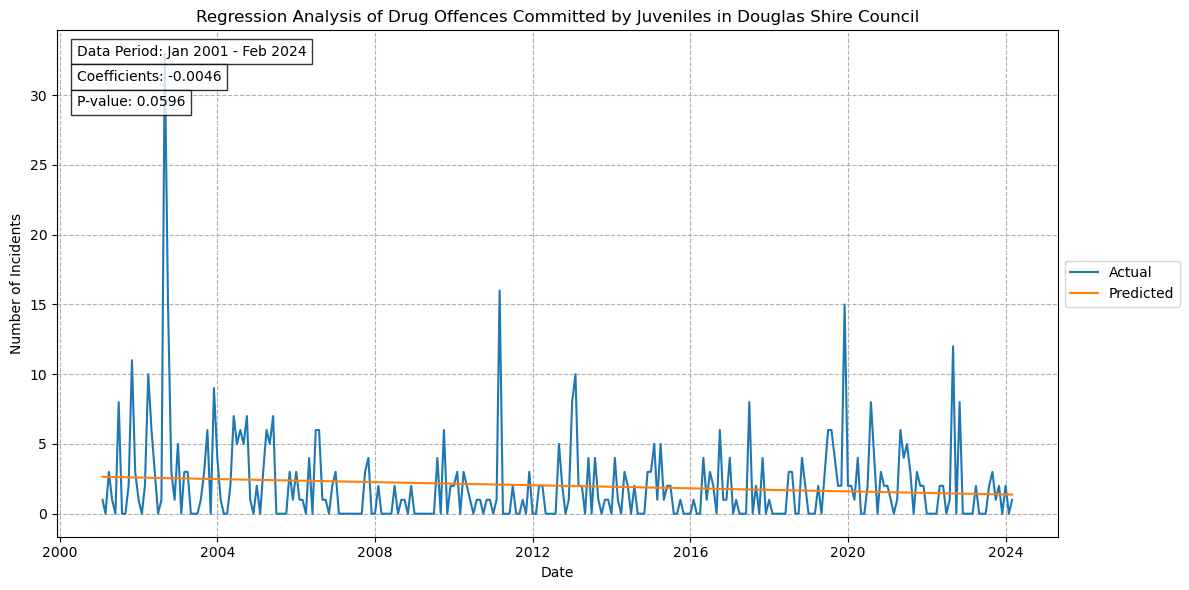

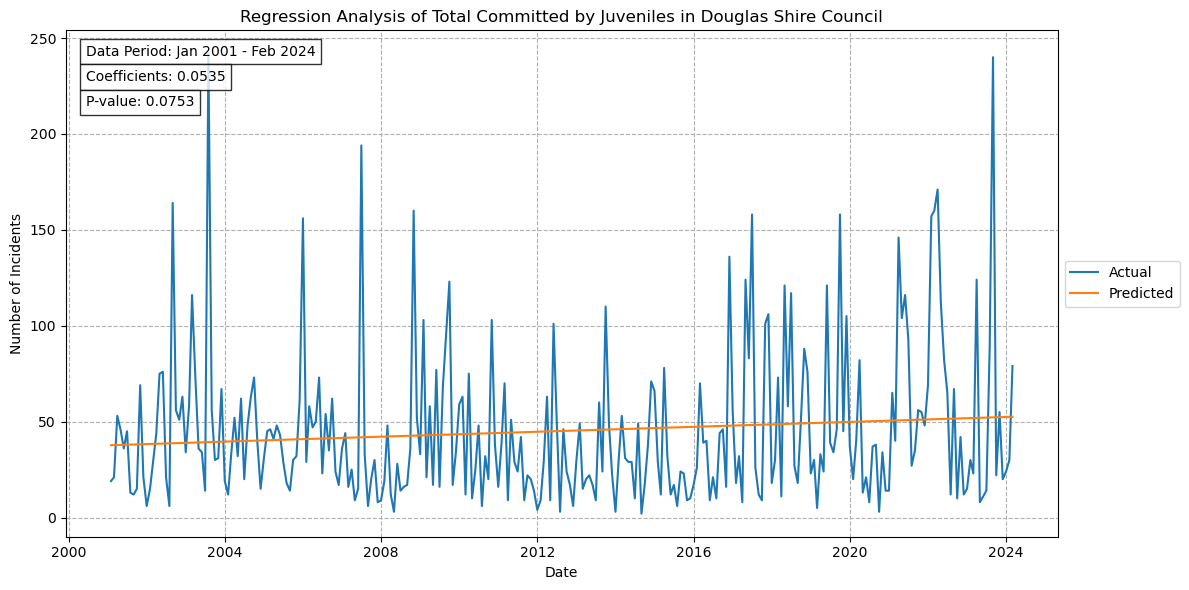

In [5]:
# %%
def perform_regression_analysis(data, offence):
    """Perform regression analysis on a specific offence."""
    offence_data = data[[offence]]
    offence_data = offence_data.resample('M').sum()
    offence_data = offence_data.fillna(0)

    X = np.arange(len(offence_data)).reshape(-1, 1)
    y = offence_data[offence].values

    model = sm.OLS(y, sm.add_constant(X)).fit()
    predictions = model.predict(sm.add_constant(X))

    # Determine the data period
    start_date = data.index.min().strftime('%b %Y')
    end_date = data.index.max().strftime('%b %Y')
    data_period = f"{start_date} - {end_date}"

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(offence_data.index, y, label='Actual')
    plt.plot(offence_data.index, predictions, label='Predicted')
    plt.title(f'Regression Analysis of {offence} Committed by Juveniles in Douglas Shire Council')
    plt.xlabel('Date')
    plt.ylabel('Number of Incidents')
    plt.grid(linestyle='--')

    # Add data period
    plt.text(0.02, 0.95, f'Data Period: {data_period}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Add regression statistics
    plt.text(0.02, 0.90, f'Coefficients: {model.params[1]:.4f}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.02, 0.85, f'P-value: {model.pvalues[1]:.4f}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Move legend to the right
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

# %%
# Perform regression analysis on top 5 offences and total
    
top_offences = get_top_offences(juveniles_data, 5)
top_offences_plus_total = top_offences + ['Total']

for offence in top_offences_plus_total:
    perform_regression_analysis(juveniles_data_preprocessed, offence)

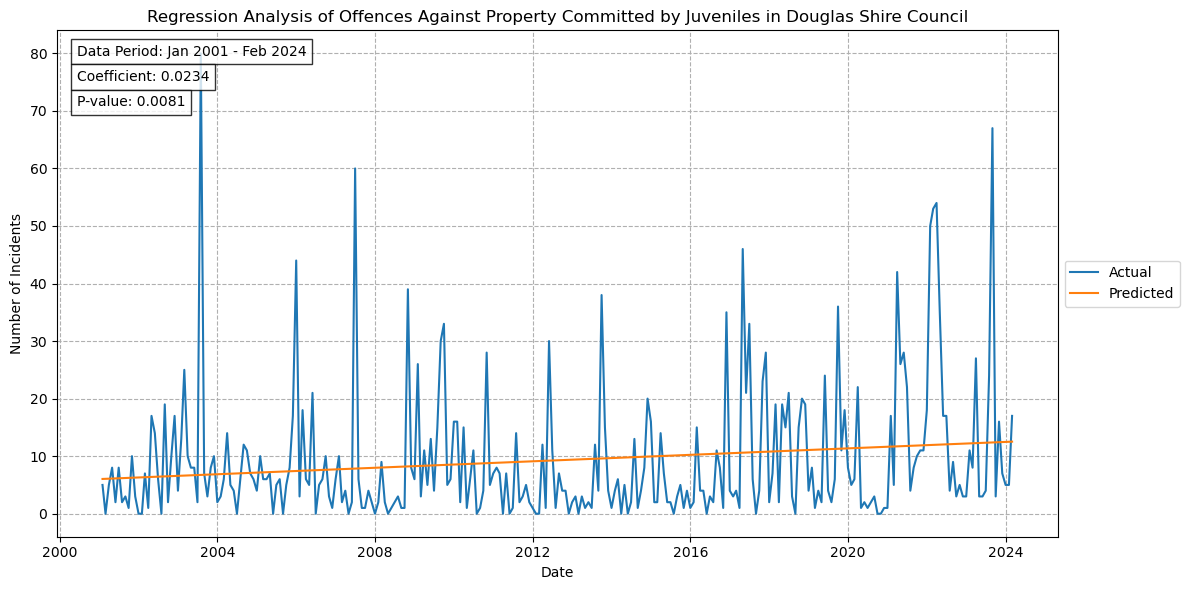

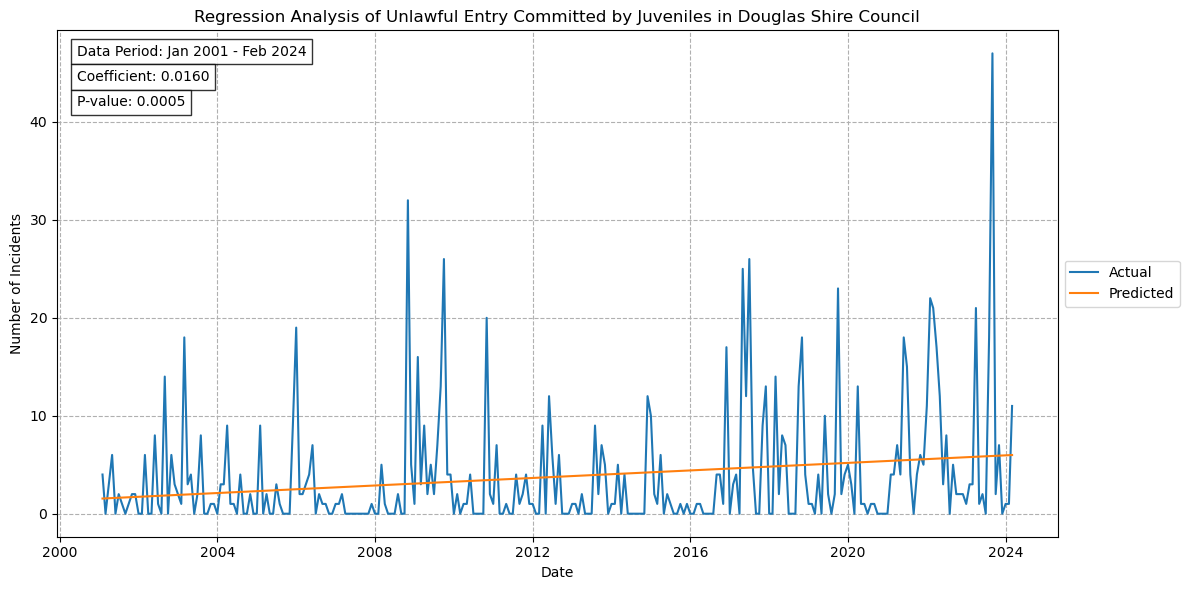

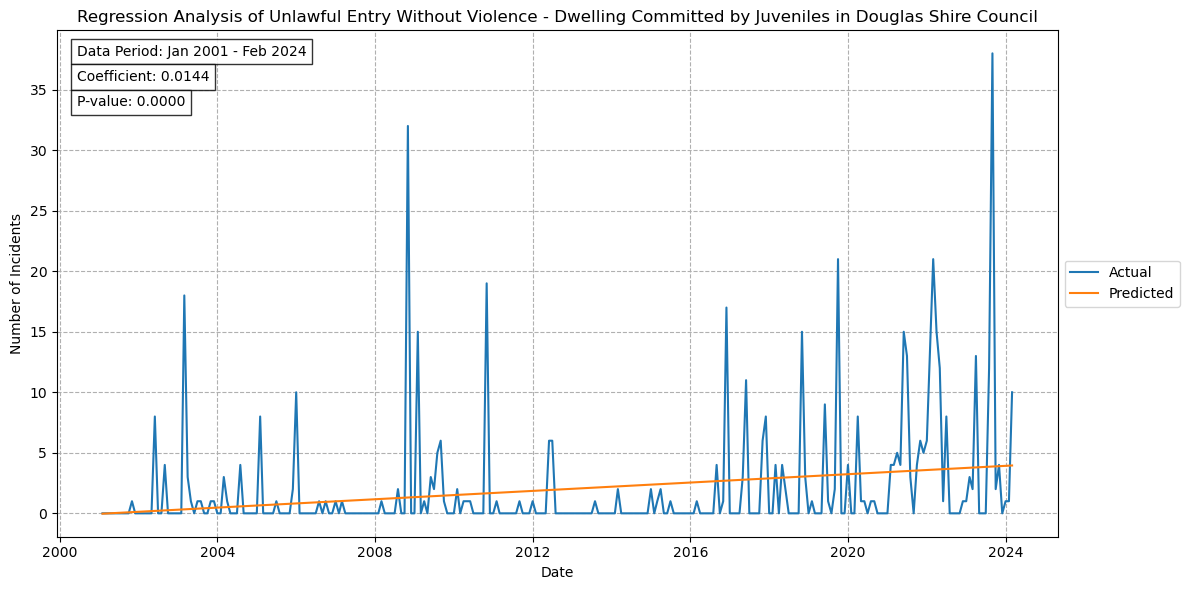

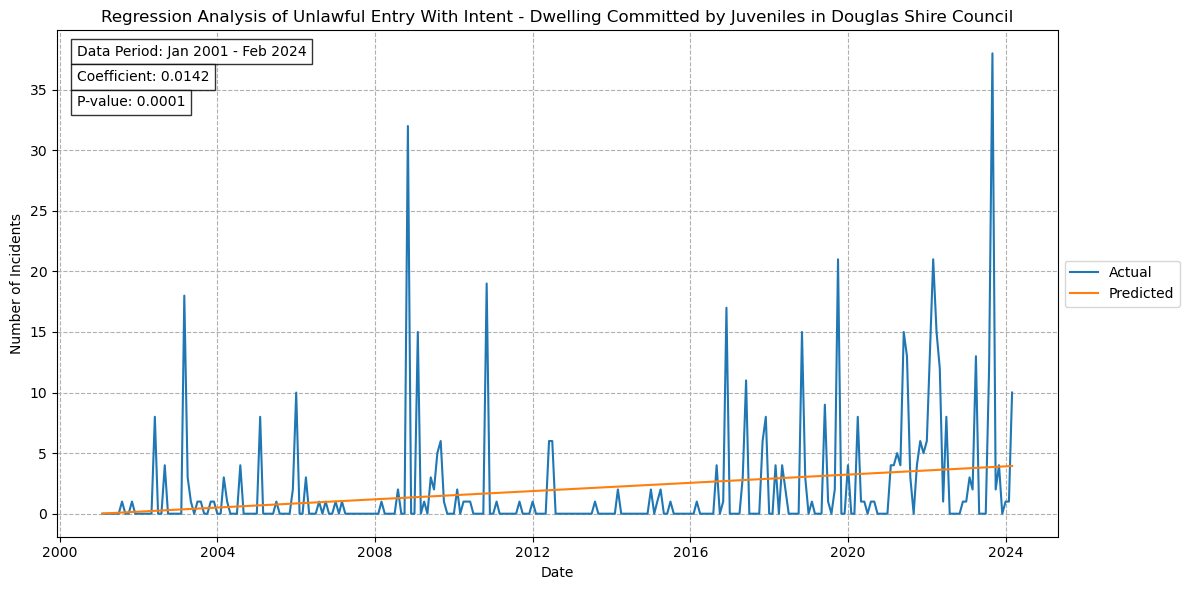

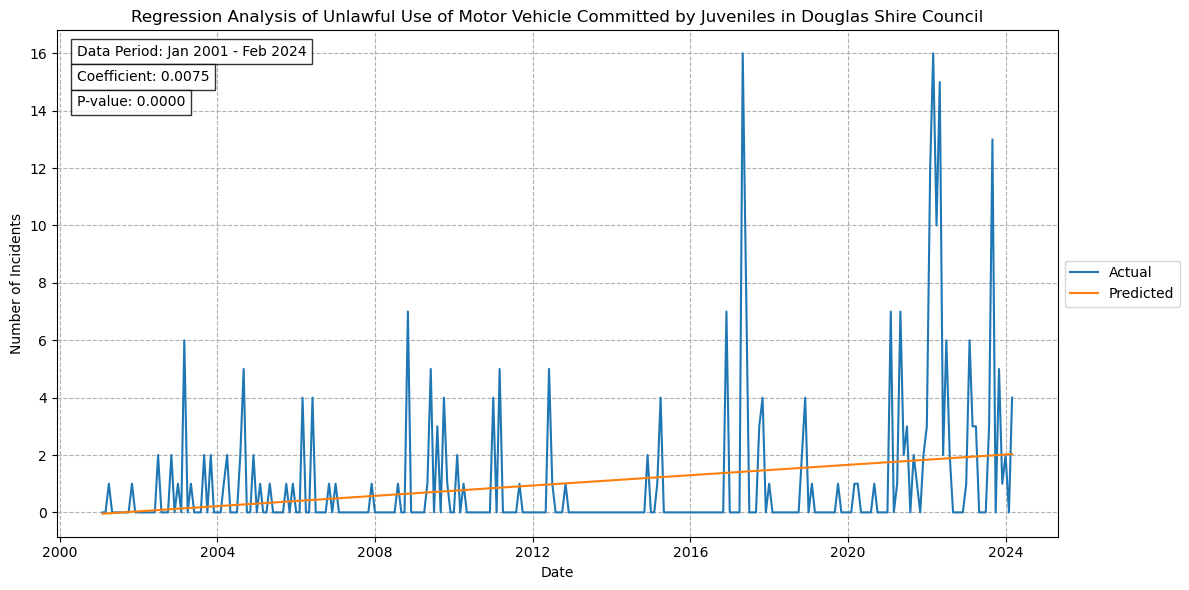

In [11]:
# %%
def perform_regression_analysis(data):
    """Perform regression analysis on each offence category."""
    offence_columns = data.columns.drop(['LGA Name', 'Month Year', 'Age', 'Sex', 'Total'])
    regression_results = []

    for offence in offence_columns:
        offence_data = data[['Month Year', offence]].copy()
        offence_data.loc[:, 'Month Year'] = pd.to_datetime(offence_data['Month Year'], format='%b-%y')
        offence_data.set_index('Month Year', inplace=True)
        offence_data = offence_data.resample('M').sum()
        offence_data.fillna(0, inplace=True)

        X = np.arange(len(offence_data)).reshape(-1, 1)
        y = offence_data[offence].values

        model = sm.OLS(y, sm.add_constant(X)).fit()
        coefficient = model.params[1]
        p_value = model.pvalues[1]

        regression_results.append((offence, coefficient, p_value))

    return regression_results

# %%
def plot_top_5_regression_coefficients(data, regression_results):
    """Plot the 5 offence categories with the highest regression coefficients."""
    regression_results.sort(key=lambda x: x[1], reverse=True)
    top_5_offences = [result[0] for result in regression_results[:5]]

    for offence in top_5_offences:
        offence_data = data[['Month Year', offence]].copy()
        offence_data.loc[:, 'Month Year'] = pd.to_datetime(offence_data['Month Year'], format='%b-%y')
        offence_data.set_index('Month Year', inplace=True)
        offence_data = offence_data.resample('M').sum()
        offence_data.fillna(0, inplace=True)

        X = np.arange(len(offence_data)).reshape(-1, 1)
        y = offence_data[offence].values

        model = sm.OLS(y, sm.add_constant(X)).fit()
        predictions = model.predict(sm.add_constant(X))

        # Determine the data period
        start_date = offence_data.index.min().strftime('%b %Y')
        end_date = offence_data.index.max().strftime('%b %Y')
        data_period = f"{start_date} - {end_date}"

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(offence_data.index, y, label='Actual')
        plt.plot(offence_data.index, predictions, label='Predicted')
        plt.title(f'Regression Analysis of {offence} Committed by Juveniles in Douglas Shire Council')
        plt.xlabel('Date')
        plt.ylabel('Number of Incidents')
        plt.grid(linestyle='--')

        # Add data period
        plt.text(0.02, 0.95, f'Data Period: {data_period}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        # Add regression statistics
        plt.text(0.02, 0.90, f'Coefficient: {model.params[1]:.4f}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        plt.text(0.02, 0.85, f'P-value: {model.pvalues[1]:.4f}', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        # Move legend to the right
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

# %%
# Perform regression analysis on each offence category
regression_results = perform_regression_analysis(juveniles_data)

# Plot the 5 offence categories with the highest regression coefficients
plot_top_5_regression_coefficients(juveniles_data, regression_results)

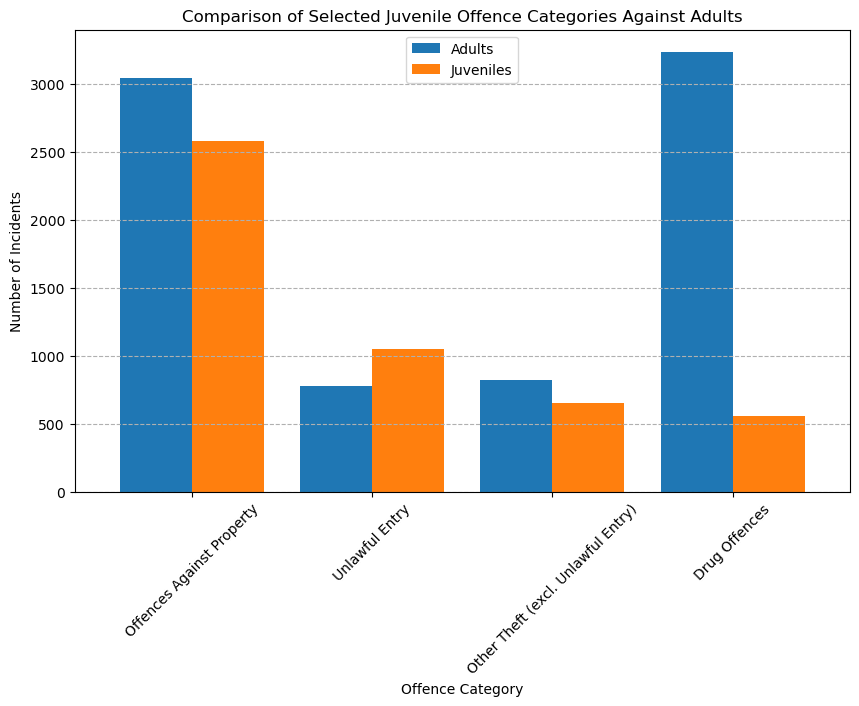

In [ ]:
def focused_comparison(adults_data, juveniles_data, top_offences):
    """Perform focused comparison excluding 'Other Offences' and 'Total'."""
    focused_offences = [offence for offence in top_offences if offence not in ['Other Offences', 'Total']]
    adult_focused_totals = adults_data[focused_offences].sum()
    juvenile_focused_totals = juveniles_data[focused_offences].sum()

    focused_totals_df = pd.DataFrame({'Adults': adult_focused_totals, 'Juveniles': juvenile_focused_totals})

    focused_totals_df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Comparison of Selected Juvenile Offence Categories Against Adults')
    plt.ylabel('Number of Incidents')
    plt.xlabel('Offence Category')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.show()

# Perform focused comparison
focused_comparison(adults_data, juveniles_data, top_offences)

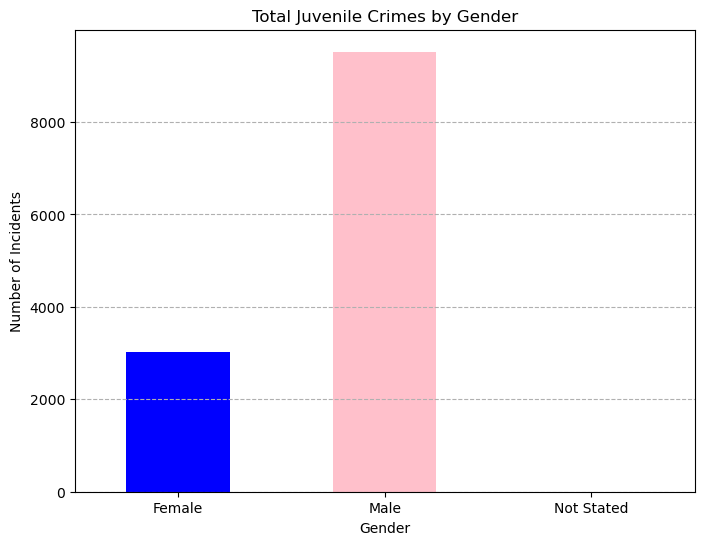

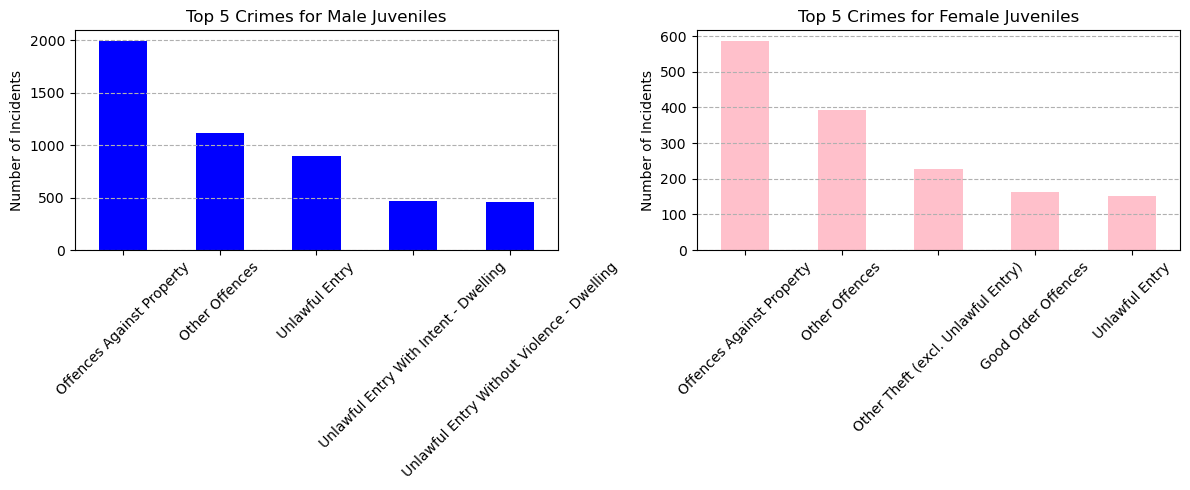

In [ ]:
def analyze_and_plot_gender_data(juveniles_data):
    """Analyze and plot gender data."""
    gender_totals = juveniles_data.groupby('Sex')['Total'].sum()

    male_top_crimes = juveniles_data[juveniles_data['Sex'] == 'Male'].drop(
        columns=['LGA Name', 'Month Year', 'Age', 'Sex', 'Total']
    ).sum().sort_values(ascending=False).head(5)
    
    female_top_crimes = juveniles_data[juveniles_data['Sex'] == 'Female'].drop(
        columns=['LGA Name', 'Month Year', 'Age', 'Sex', 'Total']
    ).sum().sort_values(ascending=False).head(5)

    gender_totals.plot(kind='bar', figsize=(8, 6), color=['blue', 'pink'])
    plt.title('Total Juvenile Crimes by Gender')
    plt.ylabel('Number of Incidents')
    plt.xlabel('Gender')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    male_top_crimes.plot(kind='bar', color='blue')
    plt.title('Top 5 Crimes for Male Juveniles')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')

    plt.subplot(1, 2, 2)
    female_top_crimes.plot(kind='bar', color='pink')
    plt.title('Top 5 Crimes for Female Juveniles')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

# Analyze and plot gender data
analyze_and_plot_gender_data(juveniles_data)